# Image Denoising

**Image denoising**, using an _autoencoder_, inspired into Francois Chollet [tutorial](https://blog.keras.io/building-autoencoders-in-keras.html).

## Libraries

In [1]:
import keras
from keras import layers
from keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt

## Data

Here, we are using as our data the [MNIST](https://keras.io/api/datasets/mnist/) dataset.

This is a dataset of 60 000 images of size 28 $\times$ 28 grayscale images of hand written of 10 digits (0, 1, 2, 3, 4, 5, 6, 7, 8, 9), along with a test set of 10 000 images.

### Importing data

This dataset is mostly used in _classification problems_, that is why they have the images and a second information, the labels of each image.

But, as we are going to map digits images to clean them, we are not going to use the labels.

In this way, our process is going to take the **noised images** and clear the same based into the **true images** as _targets_.

In [2]:
(x_train, _), (x_test, _) = mnist.load_data()

In [3]:
x_train.shape, x_test.shape

((60000, 28, 28), (10000, 28, 28))

In [4]:
dimension = x_train.shape[1]

### Pre-processing data

Because here we are doing a simple example, we will use a fraction of the complete dataset: just 1000 images, dividing if on 700 as _train_ and 300 images as _test_.

In [5]:
num_data = 1000
frac_train = 0.7
frac_test = 0.3
x_train = x_train[0:int(frac_train*num_data)]
x_test = x_test[0:int(frac_test*num_data)]

We are going to normalize the images between 0 and 1 and to reshape them.

In [6]:
norm_factor = 255.
x_train = x_train.astype('float32')/norm_factor
x_test = x_test.astype('float32')/norm_factor
x_train = np.reshape(x_train, (len(x_train), dimension, dimension, 1))
x_test = np.reshape(x_test, (len(x_test), dimension, dimension, 1))

Here, we need to noisy the images, then, we apply a Gaussian noisy matrix and clip the images between 0 and 1.

In [7]:
noise_factor = 0.5
x_train_noisy = x_train + noise_factor * np.random.normal(loc = 0.0, scale = 1.0, size = x_train.shape) 
x_test_noisy = x_test + noise_factor * np.random.normal(loc = 0.0, scale = 1.0, size = x_test.shape) 

x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

Visualizing some noise images.

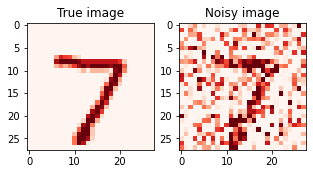

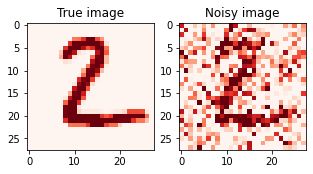

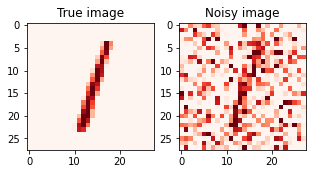

In [8]:
n = 3
for i in range(n):
    fig, axes = plt.subplots(1, 2)
    fig.set_size_inches(5, 5)
    axes[0].set_title('True image')
    im0 = axes[0].imshow(x_test[i].reshape(dimension, dimension), cmap = 'Reds')
    axes[1].set_title('Noisy image')
    im1 = axes[1].imshow(x_test_noisy[i].reshape(dimension, dimension), cmap = 'Reds')

## Building the Autoencoder

Defining the input images for the **autoencoder**.

In [9]:
input_img = keras.Input(shape = (dimension, dimension, 1))

### Encoder

In [10]:
x = layers.Conv2D(filters = 32, kernel_size = (3, 3), activation = 'relu', padding = 'same')(input_img)
x = layers.MaxPooling2D(pool_size = (2, 2), padding = 'same')(x)
x = layers.Conv2D(filters = 32, kernel_size = (3, 3), activation = 'relu', padding = 'same')(x)
encoded = layers.MaxPooling2D(pool_size = (2, 2), padding = 'same')(x)

Metal device set to: Apple M1

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB



2022-07-18 17:54:19.427339: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-07-18 17:54:19.427808: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


### Decoder

In [11]:
x = layers.Conv2D(filters = 32, kernel_size = (3, 3), activation = 'relu', padding = 'same')(encoded)
x = layers.UpSampling2D(size = (2, 2))(x)
x = layers.Conv2D(filters = 32, kernel_size = (3, 3), activation = 'relu', padding = 'same')(x)
x = layers.UpSampling2D(size = (2, 2))(x)
decoded = layers.Conv2D(filters = 1, kernel_size = (3, 3), activation = 'sigmoid', padding = 'same')(x)

### Autoencoder

In [12]:
autoencoder = keras.Model(input_img, decoded)

Visualizing the autoencoder.

In [13]:
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 32)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 7, 32)          9248  

### Compilation

In [14]:
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

### Fitting

In [15]:
validation_split = 0.8
history = autoencoder.fit(x_train_noisy, x_train, epochs = 40, batch_size = 20, shuffle = True, validation_split = validation_split)

Epoch 1/40


2022-07-18 17:54:29.303653: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-07-18 17:54:29.613093: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


7/7 [==============================] - ETA: 0s - loss: 0.5789

2022-07-18 17:54:31.354419: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


7/7 [==============================] - 3s 162ms/step - loss: 0.5789 - val_loss: 0.5098
Epoch 2/40
7/7 [==============================] - 0s 48ms/step - loss: 0.5024 - val_loss: 0.4718
Epoch 3/40
7/7 [==============================] - 0s 47ms/step - loss: 0.4635 - val_loss: 0.4389
Epoch 4/40
7/7 [==============================] - 0s 47ms/step - loss: 0.4278 - val_loss: 0.4009
Epoch 5/40
7/7 [==============================] - 0s 46ms/step - loss: 0.3811 - val_loss: 0.3477
Epoch 6/40
7/7 [==============================] - 0s 47ms/step - loss: 0.3198 - val_loss: 0.2839
Epoch 7/40
7/7 [==============================] - 0s 48ms/step - loss: 0.2605 - val_loss: 0.2401
Epoch 8/40
7/7 [==============================] - 0s 55ms/step - loss: 0.2287 - val_loss: 0.2226
Epoch 9/40
7/7 [==============================] - 0s 47ms/step - loss: 0.2161 - val_loss: 0.2141
Epoch 10/40
7/7 [==============================] - 0s 47ms/step - loss: 0.2079 - val_loss: 0.2069
Epoch 11/40
7/7 [======================

### Tracking the history of the training stage

In [16]:
history.history.keys()

dict_keys(['loss', 'val_loss'])

In [17]:
train_loss = history.history['loss']
train_val_loss = history.history['val_loss']
epochs = range(1, len(train_loss) + 1)

Visualizing the history of the training.

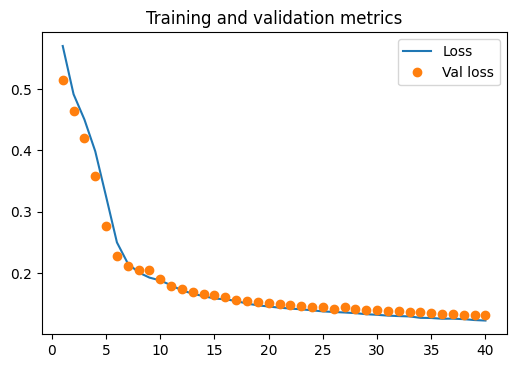

In [18]:
plt.figure(dpi = 100)
plt.plot(epochs, train_loss, label = 'Loss')
plt.plot(epochs, train_val_loss, 'o', label = 'Val loss')
plt.title('Training and validation metrics')
plt.legend()
plt.savefig('history.png')

### Prediction

In [19]:
all_denoised_images = autoencoder.predict(x_test_noisy)

 1/10 [==>...........................] - ETA: 1s

2022-07-12 19:28:33.876163: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


10/10 [==============================] - 0s 19ms/step


### Evaluation

In [20]:
test_loss  = autoencoder.evaluate(x_test_noisy, x_test, batch_size = 20)
test_loss

15/15 [==============================] - 0s 6ms/step - loss: 0.1287


0.12868081033229828

# Visual results

Here, we can compare our visual results looking side by side the noisy, targets and denoised  images.

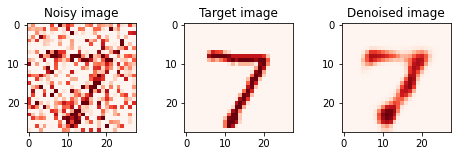

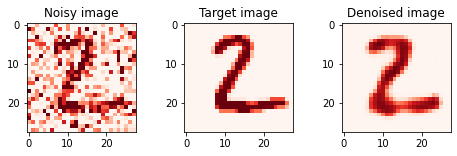

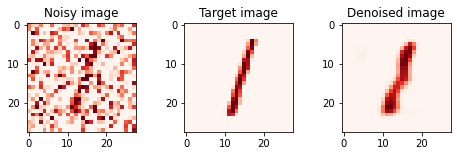

In [21]:
n = 3
for i in range(n):
    fig, axes = plt.subplots(1, 3)
    fig.set_size_inches(8, 2)
    axes[0].set_title('Noisy image')
    im0 = axes[0].imshow(x_test_noisy[i].reshape(dimension, dimension), cmap = 'Reds')
    axes[1].set_title('Target image')
    im1 = axes[1].imshow(x_test[i].reshape(dimension, dimension), cmap = 'Reds')
    axes[2].set_title('Denoised image')
    im2 = axes[2].imshow(all_denoised_images[i].reshape(dimension, dimension), cmap = 'Reds')
    plt.savefig(f'comparison-{i}.png')